## RL-Algorithmen

In [1]:
# HIDDEN
import gym
import time
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["font.size"] = 14

In [2]:
# HIDDEN
import ray
import logging
ray.init(log_to_driver=False, ignore_reinit_error=True, logging_level=logging.ERROR) # logging.FATAL

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#### RL-Algorithmen

- Wir haben den PPO-Algorithmus für fast den gesamten Kurs verwendet (außer Offline-RL)
- Tatsächlich bietet RLlib viele Algorithmen! Siehe [hier](https://docs.ray.io/en/latest/rllib/rllib-algorithms.html).
- Schauen wir uns einen weiteren Algorithmus an: DQN.

Anmerkungen:

Zum Zeitpunkt der Aufzeichnung gibt es über 20 Algorithmen.

#### Deep Q-Network (DQN)

- DQN ist in der RL-Welt für viele Durchbrüche wie die [Atari-Ergebnisse](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) aus dem Jahr 2013 bekannt.
- In RLlib müssen wir nur die kleinsten Vertauschungen vornehmen:

PPO:

In [3]:
from ray.rllib.algorithms.ppo import PPOConfig

ppo = PPOConfig().framework("torch").debugging(log_level="ERROR").build(env="FrozenLake-v1")

DQN:

In [4]:
from ray.rllib.algorithms.dqn import DQNConfig

dqn = DQNConfig().framework("torch").debugging(log_level="ERROR").build(env="FrozenLake-v1")

Und das war's!

#### PPO vs. DQN auf dem gefrorenen See

In [5]:
t = time.time()
ppo_results = []
for i in range(50):
    ppo_results.append( ppo.train()["episode_reward_mean"] )
print(f"Elapsed time {time.time()-t:.1f} s")

Elapsed time 175.6 s


In [6]:
t = time.time()
dqn_results = []
for i in range(50):
    dqn_results.append( dqn.train()["episode_reward_mean"] )
print(f"Elapsed time {time.time()-t:.1f} s")

Elapsed time 134.8 s


#### PPO vs. DQN auf dem gefrorenen See

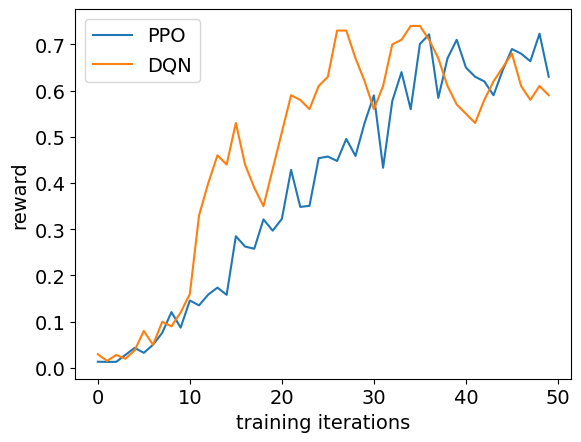

In [7]:
plt.plot(ppo_results, label="PPO")
plt.plot(dqn_results, label="DQN")
plt.legend()
plt.xlabel("training iterations")
plt.ylabel("reward")

- In diesem speziellen Fall scheinen die beiden Algorithmen etwa gleich gut zu funktionieren.
- Aber im Allgemeinen kann einer besser geeignet sein als der andere.

Anmerkungen:

Wie beim überwachten Lernen ist auch hier ein empirischer Ansatz sinnvoll, wenn du keine Fachkenntnisse hast: Probiere mehrere Algorithmen aus. PPO ist ein Arbeitspferd des RL, ähnlich wie ein Random Forest oder XGBoost in SL. Deshalb haben wir uns in diesem Kurs darauf konzentriert.

#### On-Policy vs. Off-Policy

- Unter der Haube funktionieren PPO und DQN sehr unterschiedlich
- PPO ist ein **on-Policy** Algorithmus, DQN ist **off-Policy**
- Dadurch ist DQN _sample-effizienter_ als PPO.
- Sie haben auch Gemeinsamkeiten, z.B. sind beide _modellfreie_ Methoden

Anmerkungen:

- PPO trainiert, während es seine eigene Policy durchführt
- DQN kann auf _Erfahrungen_ trainieren, die von einer anderen Policy stammen können (verwandt mit Offline-RL)
- DQN lernt wie Offline-RL (aus Daten), aber es generiert kontinuierlich neue Daten aus der Environment
- Da DQN aus Erfahrungen lernen kann, kann es Erfahrungen speichern und wiederverwenden, was bedeutet, dass es den Simulator weniger nutzt. Dadurch ist es stichprobeneffizienter. PPO ist weniger stichprobeneffizient, da es ständig neue Daten generieren muss, um die Policy zu aktualisieren.

#### Q-Werte

- Ein großer Unterschied ist, dass das DQN direkt _Q-Werte_ lernt
- Für jedes Paar aus Zustand und Aktion ist ein Q-Wert ein Maß dafür, wie "gut" es ist, diese Aktion auszuführen.
- Schauen wir uns das mal an:

In [8]:
# HIDDEN
import utils_05

In [9]:
env = gym.make("FrozenLake-v1")
utils_05.get_q_state_action(dqn, env, 3) # See GitHub for the source code

array([-0.09853268, -0.14336044, -0.11489896,  0.03309561], dtype=float32)

Anmerkungen:

- Die Interpretation ähnelt _einigermaßen_ den Aktionswahrscheinlichkeiten, die wir mit PPO gesehen haben, aber diese Werte sind _keine_ Wahrscheinlichkeiten.
- Dies stimmt mit dem überein, was wir in Modul 2 gesehen haben, wo wir gesehen haben, dass der Agent in dieser Situation versucht, sich an den Rand der Karte zu bewegen (in diesem Fall mit PPO).

#### Q-Werte

Hier sind die Q-Werte für alle 16 möglichen Beobachtungen:

In [10]:
q_sa = np.array([utils_05.get_q_state_action(dqn, env, i) for i in range(16)])
q_sa

array([[ 0.0250557 ,  0.00189328,  0.0147118 , -0.00491313],
       [-0.10207751, -0.1235072 , -0.09499033,  0.09698348],
       [ 0.0095781 , -0.00549703, -0.02182595,  0.0157672 ],
       [-0.09853268, -0.14336044, -0.11489896,  0.03309561],
       [ 0.15369992, -0.03664979, -0.08071145, -0.0773018 ],
       [-0.07337078,  0.05233519,  0.02065156,  0.15142277],
       [ 0.06925851,  0.00942715,  0.08151763, -0.06434247],
       [-0.01687239,  0.0129228 , -0.00735277,  0.00816823],
       [-0.129724  , -0.11653047, -0.12724674,  0.10552808],
       [-0.07872174,  0.13974991, -0.07383227, -0.0811846 ],
       [ 0.19561987,  0.10555127,  0.03701289, -0.07053802],
       [ 0.00053562, -0.08337303,  0.01945995,  0.02803568],
       [-0.20200473, -0.01184962,  0.0397765 ,  0.02301433],
       [-0.03505937, -0.00177202,  0.23518673, -0.13724004],
       [-0.02729543,  0.16112214,  0.0815852 ,  0.02503811],
       [ 0.05104231,  0.06634373,  0.14945373,  0.03831675]],
      dtype=float32)

#### Q-Werte

Wir können diese 64 (16x4) Q-Werte aufzeichnen:

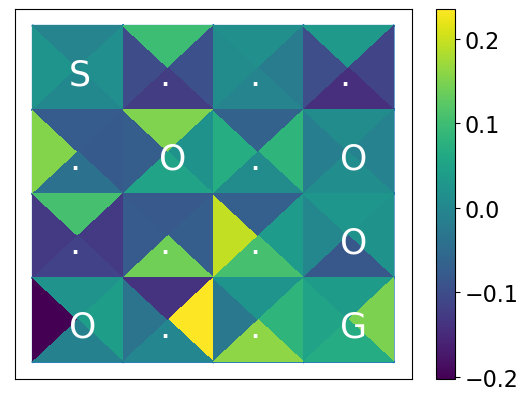

In [11]:
utils_05.q_state_action_plot_frozenlake(q_sa, env) # See GitHub for source code

Eine ähnliche Darstellung haben wir in Modul 2 mit den PPO-Aktionswahrscheinlichkeiten gesehen.

Beobachtungen:

- Wir sehen wieder den Wunsch, von oben rechts aufzusteigen.
- Der stärkste Wunsch ist es, nicht auf Feld 10 zu sterben. Nach links zu gehen ist der einzig 100% sichere Weg.
- Warum bei Feld 14 nach unten gehen? Weil 13 besser ist als 10.
  - Du kannst das bestätigen, indem du zum Q-Wert-Diagramm zurückscrollst.

#### Zustand Q-Werte

Es gibt auch Q-Werte für jeden Zustand, unabhängig von den Aktionen. Richten wir unsere Aufmerksamkeit auf diese.

In [12]:
utils_05.get_q_state(dqn, env, 3) # See GitHub for the source code

0.2558417320251465

- Offenbar hat die Beobachtung "3" (Spieler oben rechts) einen "Wert" von 0,16.
- Die Einheit dieses "Wertes" ist die erwartete diskontierte Gesamtbelohnung.
  - Erinnere dich daran, dass wir die Diskontierung in Modul 4 besprochen haben!

Bei PPO sind die Q-Werte nicht verfügbar:

In [13]:
utils_05.get_q_state(ppo, env, 3)

AttributeError: 'FullyConnectedNetwork' object has no attribute 'get_state_value'

Anmerkungen:

Bei Frozen Lake sind alle Werte kleiner als 1, weil 1 die maximale Belohnung für eine Episode ist. Selbst wenn ein Agent sicher ist, dass er das Ende erreichen wird, ist der Wert aufgrund der Diskontierung kleiner als 1 

Wegen der Diskontierung sollten wir diese 0,16 nicht als Wahrscheinlichkeit für das Erreichen des Ziels interpretieren.

#### Q-Werte

Wir können uns diese für alle 16 Beobachtungen in einem Diagramm ansehen:

In [14]:
q_s = [utils_05.get_q_state(dqn, env, i) for i in range(16)]

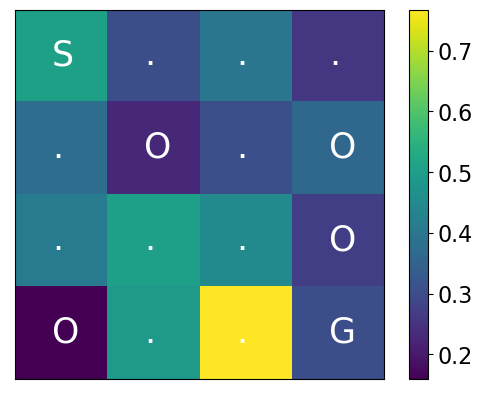

In [15]:
utils_05.q_state_plot_frozenlake(q_s, env) # See GitHub for the source code

- Kehren wir zu dem zurück, was wir in Modul 2 gesehen haben, nämlich dass der Agent von Ort 14 _nach unten_ gehen wollte.
- Jetzt können wir sehen, dass der Zustand 10 einen niedrigeren Wert hat als der Zustand 14.
- Obwohl PPO nicht explizit eine Wertfunktion für jeden Zustand darstellt, könnte dies die "Logik" sein.

Anmerkungen:
    
Hier sehen wir, dass der wünschenswerteste Zustand derjenige ist, der vor dem Ziel liegt. Wir können auch sehen, dass die Zustände höhere Q-Werte haben, je näher sie dem Ziel kommen. Vergiss nicht, dass es sich hier um den rutschigen Frozen Lake handelt, also ist der Sieg nicht garantiert und näher am Ziel zu sein, ist tatsächlich besser.

Die Q-Werte für die Endzustände (O und G) sehen nicht besonders aussagekräftig aus 

#### Interna des Policy-Netzwerks

- In Modul 2 haben wir `query_Policy` und hier `get_q_state` und `get_q_state_action` benutzt.
- Wie sehen diese Funktionen eigentlich aus?
- Hier ist `get_q_state`.

In [16]:
import torch
from ray.rllib.models.preprocessors import get_preprocessor 

def get_q_state(algo, env, obs):
    model = algo.get_policy().model
    prep = get_preprocessor(env.observation_space)(env.observation_space)
    model_output = model({"obs": torch.from_numpy(prep.transform(obs)[None])})[0]
    return float(model.get_state_value(model_output))

- Lass uns diesen Code Schritt für Schritt auspacken.
- Zu deiner Information: Die nächsten Folien setzen eine gewisse Vertrautheit mit Deep Learning und neuronalen Netzen voraus.
- Wenn das nicht dein Ding ist, kannst du sie getrost überspringen.

#### Interna des Policy-Netzwerks: Modell

In [17]:
model = dqn.get_policy().model

In [18]:
model

FullyConnectedNetwork_as_DQNTorchModel(
  (_hidden_layers): Sequential(
    (0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=16, out_features=256, bias=True)
        (1): Tanh()
      )
    )
    (1): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): Tanh()
      )
    )
  )
  (_value_branch): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (advantage_module): Sequential(
    (dueling_A_0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (A): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=4, bias=True)
      )
    )
  )
  (value_module): Sequential(
    (dueling_V_0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (V): 

Anmerkungen:

Hier sehen wir die Interna des Policy-Netzwerks, das ein tiefes neuronales Netzwerk ist, das in pytorch implementiert wurde. Wir können die Details des Netzwerks sehen, wie die versteckten Schichten, Aktivierungsfunktionen (hier ReLU), die Anzahl der versteckten Einheiten, usw.  

#### Interna des Policy-Netzwerks: Präprozessor

In [19]:
prep = get_preprocessor(env.observation_space)(env.observation_space)

In [20]:
prep

- Das ist interessant. Vielleicht bist du in deiner DL- oder ML-Arbeit schon einmal auf One-Hot-Codierung gestoßen.
- Unser Beobachtungsraum ist "diskret(16)".
  - Und die Beobachtung ist die Eingabe für ein neuronales Netz.
- Die Beobachtung wird also von RLlib automatisch one-hot kodiert.
- Ein Beispiel:

In [21]:
prep.transform(3)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

#### Interna des Policynetzwerks: Modellausgabe

Die nächste Zeile lautet:

In [22]:
obs = 3
model_output = model({"obs": torch.from_numpy(prep.transform(obs)[None])})[0]

1. Die Beobachtung wird durch den Präprozessor einhändig kodiert.
2. Die Beobachtung wird von einem Numpy-Array in einen Pytorch-Tensor umgewandelt.
3. Der Tensor wird an das neuronale Netz übergeben.

In [23]:
type(model_output)

torch.Tensor

In [24]:
model_output.shape

torch.Size([1, 256])

- Dies ist die Ausgabe kurz vor dem Ende des Netzwerks.
- Die Größe wäre anders, wenn wir `fcnet_hiddens` in der Konfiguration auf einen anderen Wert gesetzt hätten.

#### Policy Netzwerk Interna: Q-Wert

Und zum Schluss:

In [25]:
float(model.get_state_value(model_output))

0.2558417320251465

- Dies ist der Q-Wert für die Beobachtung 3.

Anmerkungen 

Beachte, dass `get_state_value` eine eingebaute Methode des RLlib-Modells ist, im Gegensatz zu `get_q_state` oder `query_Policy`, die separat für diesen Kurs erstellt wurden.

#### Interna des Policynetzwerks: Q-Werte für Zustandsaktionen

Der Code zum Abrufen von Q-Werten für Zustandsaktionen unterscheidet sich nur in der letzten Zeile:

In [26]:
model.get_q_value_distributions(model_output)[0].detach().numpy()[0]

array([-0.09853268, -0.14336044, -0.11489896,  0.03309561], dtype=float32)

Hier haben wir einen Q-Wert für jedes Zustands-Aktionspaar, wobei der Zustand in diesem Fall auf 3 gesetzt ist.

#### Policy-Netzwerk-Interna: Abfragerichtlinie

- Der Code für `query_Policy` verwendet ebenfalls die gleichen ersten Codezeilen.
- Wir wollen ihn jedoch für unseren PPO-Agenten verwenden.

In [27]:
model = ppo.get_policy().model
prep = get_preprocessor(env.observation_space)(env.observation_space)
model_output = model({"obs": torch.from_numpy(prep.transform(obs)[None])})[0]

Anmerkungen:

Wir wiederholen dieselben ersten Zeilen, aber mit unserem PPO-Agenten.

#### Policy-Netzwerk-Interna: Abfragerichtlinie

Der Rest des Codes sieht folgendermaßen aus:

In [28]:
dist = policy.dist_class(model_output, model)

NameError: name 'policy' is not defined

⬆️ Holt eine Klasse, die die Verteilung über Aktionen repräsentiert

In [ ]:
actions = torch.from_numpy(np.array([0,1,2,3]))

⬆️ Erstelle einen pytorch Tensor mit den möglichen Aktionen für Frozen Lake

In [ ]:
logprobs = dist.logp(actions).detach().numpy()
logprobs

⬆️ Erhalte die log-Wahrscheinlichkeiten, konvertiere von pytorch tensor zu numpy array

In [ ]:
probs = np.exp(logprobs)
probs

⬆️ Nimm den Exponenten der logarithmischen Wahrscheinlichkeiten, um die Wahrscheinlichkeiten zu erhalten

In [ ]:
probs.sum()

⬆️ Die Wahrscheinlichkeiten summieren sich zu 1 😮💨

#### Zurück zu PPO vs. DQN

- PPO verwendet das neuronale Netz, um Beobachtungen auf Handlungswahrscheinlichkeiten abzubilden
- DQN nutzt das neuronale Netz, um Beobachtungen auf Q-Werte abzubilden

#### Kontinuierliche Aktionsräume

- In diesem Kurs haben wir diskrete und kontinuierliche _Beobachtungsräume_ verwendet, aber nur diskrete _Aktionsräume_.
- Beispiel für einen kontinuierlichen Aktionsraum: Auf welchen Winkel soll das Lenkrad in einem Auto eingestellt werden?
- PPO kann auch bei einem kontinuierlichen Aktionsraum verwendet werden: Es lernt eine Wahrscheinlichkeitsverteilung über Aktionen.
- DQN kann nicht direkt auf einen kontinuierlichen Aktionsraum angewendet werden 

#### Jenseits des DQN

- Es gibt viele RL-Algorithmen, und jedes Jahr werden neue erfunden!
- DQN: 2013, PPO: 2017, ...
- Wie beim Deep Learning entwickelt sich auch das RL schnell weiter.

#### Lass uns das Gelernte anwenden!

## PPO vs. DQN
<!-- multiple choice -->

Welcher Algorithmus ist besser, PPO oder DQN?

- [x] PPO ist der empfohlene Ausgangspunkt für die meisten Probleme, aber DQN kann manchmal besser geeignet sein.
- [ ] DQN ist unser empfohlener Ausgangspunkt für die meisten Probleme, aber PPO kann manchmal besser geeignet sein.
- [ ] PPO ist immer eine bessere Wahl als DQN.
- [ ] DQN ist immer eine bessere Wahl als PPO.

## Schaltalgorithmen in RLlib
<!-- multiple choice -->

Wie kann man in RLlib zu einem anderen RL-Algorithmus wechseln?

- [ ] Ändere in der Konfiguration den Parameter `algo`, z.B. `config.training(algo="DQN")
- [ ] Gib dies beim Aufruf von `.train()` an, z.B. `algo.train("DQN")`
- [ ] Instanziiere die Basiskonfiguration für diesen Algorithmus, z.B. `DQNConfig()` anstelle von `PPOConfig()`
- [ ] Um RL-Algorithmen zu ändern, musst du statt RLlib ein anderes Paket wählen

## Ändern des RLlib-Algorithmus
<!-- coding exercise -->

Vervollständige den untenstehenden Code so, dass er einen Agenten in der Turnhalle [Taxi-v3](https://www.gymlibrary.ml/environments/toy_text/taxi/) (aus Modul 1) mit PPO und DQN für 10 Iterationen trainiert. Welcher Algorithmus scheint nach 10 Iterationen des Trainings besser abzuschneiden?

(Beachte: Nur weil ein Algorithmus in einer kleinen Anzahl von Iterationen besser abschneidet, heißt das nicht, dass er auch insgesamt besser ist!)

In [30]:
# EXERCISE

import matplotlib.pyplot as plt
from ray.rllib.algorithms.ppo import PPOConfig
from ____ import ____

# suppress warnings
import ray
import logging
ray.init(log_to_driver=False, ignore_reinit_error=True, logging_level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

ppo_config = (
    PPOConfig()
    .framework("torch")
    .rollouts(create_env_on_local_worker=True)
    .debugging(seed=0, log_level="ERROR")
    .training(model={"fcnet_hiddens" : [32, 32]})
    .environment(env="Taxi-v3")
)

ppo = ppo_config.build()

ppo_rewards = []
for i in range(10):
    out = ppo.train()
    ppo_rewards.append(out["episode_reward_mean"])
    

dqn_config = (
    ____()
    .framework("torch")
    .rollouts(create_env_on_local_worker=True)
    .debugging(seed=0, log_level="ERROR")
    .training(model={"fcnet_hiddens" : [32, 32]})
    .environment(env="Taxi-v3")
)

dqn = dqn_config.build()

dqn_rewards = []
for i in range(10):
    out = ____.train()
    dqn_rewards.append(out["episode_reward_mean"])
    
plt.plot(ppo_rewards, label="PPO")
plt.plot(dqn_rewards, label="DQN")
plt.legend()
plt.xlabel("training iterations")
plt.ylabel("reward")

-274.7

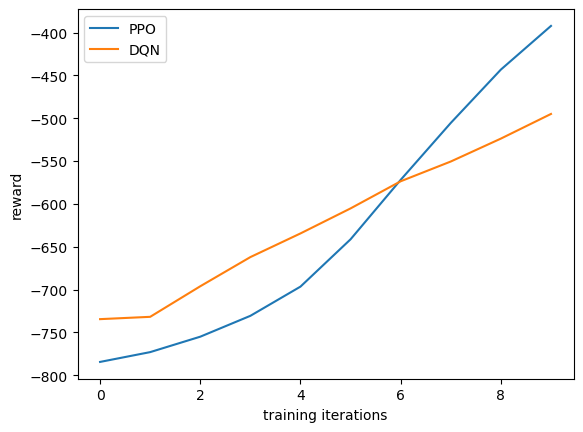

In [4]:
# SOLUTION

import numpy as np
import matplotlib.pyplot as plt
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.dqn import DQNConfig

# suppress warnings
import ray
import logging
ray.init(log_to_driver=False, ignore_reinit_error=True, logging_level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

ppo_config = (
    PPOConfig()
    .framework("torch")
    .rollouts(create_env_on_local_worker=True)
    .debugging(seed=0, log_level="ERROR")
    .training(model={"fcnet_hiddens" : [32, 32]})
    .environment(env="Taxi-v3")
)

ppo = ppo_config.build()

ppo_rewards = []
for i in range(10):
    out = ppo.train()
    ppo_rewards.append(out["episode_reward_mean"])
    

dqn_config = (
    DQNConfig()
    .framework("torch")
    .rollouts(create_env_on_local_worker=True)
    .debugging(seed=0, log_level="ERROR")
    .training(model={"fcnet_hiddens" : [32, 32]})
    .environment(env="Taxi-v3")
)

dqn = dqn_config.build()

dqn_rewards = []
for i in range(10):
    out = dqn.train()
    dqn_rewards.append(out["episode_reward_mean"])
    
plt.plot(ppo_rewards, label="PPO")
plt.plot(dqn_rewards, label="DQN")
plt.legend()
plt.xlabel("training iterations")
plt.ylabel("reward")

#### Welcher Algorithmus schneidet besser ab?

Welcher Algorithmus schneidet nach 10 Iterationen des Trainings in der Taxi-v3-Environment besser ab?

- [x] PPO erreicht eine höhere Belohnung
- [ ] DQN erreicht eine höhere Belohnung
- [ ] PPO und DQN erreichen die gleiche Belohnung

In [5]:
## TODO
# Could try some new sort of env and see what the preprocessor does. CartPole not interesting because no preprocessing happens. 

## Q-values in CartPole
#<!-- coding exercise -->

#Look at the Q-values for different pole angles!

In [31]:
## TODO
# Could try some new sort of env and see what the preprocessor does. CartPole not interesting because no preprocessing happens. 

In [8]:
# TODO
# or could do Q values for Taxi
# or even the recommender environment, I guess?

In [ ]:
# TODO
## Changing the network architecture
# <!-- coding exercise -->
# change fcnet_hiddens and see what happens - we can see the size of the torch tensor being different. 

In [9]:
# HIDDEN
# import numpy as np
# import matplotlib.pyplot as plt

# cartpole_config = (
#     PPOConfig()
#     .framework("torch")
#     .rollouts(create_env_on_local_worker=True)
#     .debugging(seed=0, log_level="ERROR")
#     .training(model={"fcnet_hiddens" : [256, 256]})
#     .environment()
# )

# algo = cartpole_config.build(env="FrozenLake-v1")

# for i in range(5):
#     algo.train()

# plt.plot(results)